In [1]:
import pydot
import numpy as np
from IPython.display import display, Javascript, SVG
from pydrake.examples.manipulation_station import ManipulationStation
from manipulation.scenarios import (
    AddIiwa, AddShape
)
from manipulation.meshcat_cpp_utils import (
    StartMeshcat, AddMeshcatTriad
)
from pydrake.all import (
    Adder, Frame,AngleAxis,
    AddMultibodyPlantSceneGraph, BasicVector, DiagramBuilder, MeshcatVisualizerCpp, MeshcatVisualizerParams, Parser, 
    RollPitchYaw, RigidTransform, RevoluteJoint, Sphere, Simulator, InverseDynamicsController, MultibodyPlant, PiecewisePolynomial,
    PiecewiseQuaternionSlerp, TrajectorySource, Quaternion,
    RotationMatrix, Rgba, LeafSystem, Integrator, PassThrough, Demultiplexer, JacobianWrtVariable, Multiplexer, SceneGraph, StateInterpolatorWithDiscreteDerivative
)
import pydrake.all

import pandas as pd

def dataframe(trajectory, times, names):
    assert trajectory.rows() == len(names)
    values = trajectory.vector_values(times)
    data = {'t': times }
    for i in range(len(names)):
        data[names[i]] = values[i,:]
    return pd.DataFrame(data)

import iiwa_rock_climbing.utils

In [2]:
meshcat = StartMeshcat()

In [3]:
BASE_MASS = 60
TIME_STEP = 0.01
INITIAL_JOINT_POSITIONS = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]

APPROACH_VECTOR = [[-0.15, 0, 0.5], [-0.15, 0, 0,]] # Rock frame
CONTACT_POSITION = [-1.50000000e-01,  5.49047152e-17, 1.05864376e-01] # Rock frame
GRIPPER_ORIENTATION = [1, 0, 0, 0]

# ComputeQuatFromEuler([0,np.pi/2.0,0])
# GOAL_POSE = [0.70710678, 0.        , 0.70710678, 0.        , 0.4, 0.1, 0.5]
# GOAL_POSE = [1,0,0,0,0,0,0]
GOAL_POSE = [1, 0,0, 0. , 0.55, 0.2, 0.7]

PREGRASP_DISTANCE = 0.1 # in meters
ROCK_POSE = np.concatenate([iiwa_rock_climbing.utils.ComputeQuatFromEuler([0,0,0]),
                            [0.57, 0, 0.25]])

POSITION_THRESHOLD = 0.05 # in meters

In [4]:
def AddIiwaWithHook(plant, collision_model="with_box_collision", mass=BASE_MASS, floating=True): #no_collision
    sdf_path = "iiwa_rock_climbing/models/iiwa_description/iiwa7/" + \
        f"iiwa7_{collision_model}.sdf"

    parser = Parser(plant)
    iiwa = parser.AddModelFromFile(sdf_path)
    # Set default positions:
    q0 = INITIAL_JOINT_POSITIONS
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):       
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1
            
    gripper = parser.AddModelFromFile("iiwa_rock_climbing/models/hook_convex/hook_convex.sdf", model_name="hook")
        
    # Weld gripper to iiwa
    plant.WeldFrames(
        plant.GetFrameByName("iiwa_link_7"), 
        plant.GetFrameByName("hook_link"), 
        RigidTransform(RollPitchYaw(0, -np.pi/2, 0), [-0.05, 0, 0.04]))
        
    # For gripper inline
    # RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0.07]))
    
    # Weld iiwa to base 
    base = AddShape(plant, pydrake.geometry.Box(0.2,0.2,0.2), "mobile_base", 
                    mass=mass, mu=1, color=[.5, .5, .9, 1.0])
    plant.WeldFrames(plant.GetFrameByName("mobile_base"), 
                     plant.GetFrameByName("iiwa_link_0"),
                     RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0.1]))
    
    # Weld base to world
    if not floating:
        plant.WeldFrames(plant.world_frame(), 
                         plant.GetFrameByName("mobile_base"))

    return iiwa

In [5]:
class StateController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant # Connect this to free-floating plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._G = plant.GetFrameByName("hook_link")
        self._W = plant.world_frame()
        self._base = plant.GetBodyByName("mobile_base")

        # For computing end-effector position
        self.q_port = self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
        self.X_WB_port = self.DeclareVectorInputPort("base_pose_measured", BasicVector(7))
        
        # For computing trajectory (Note: these are hard-coded for now, but could eventually
        # be converted into inputs
        self.rock_pose_measured = np.array(ROCK_POSE) # wrt world
        self.approach_start_cmd = np.array(APPROACH_VECTOR[0]) # wrt rock
        self.approach_end_cmd = np.array(APPROACH_VECTOR[1]) # wrt rock
        self.gripper_orientation_cmd = np.array(GRIPPER_ORIENTATION) # wrt rock
        self.contact_position = np.array(CONTACT_POSITION) # wrt rock
        self.position_threshold = POSITION_THRESHOLD
        
        # Create drake versions of fixed vectors
        self.X_WR = iiwa_rock_climbing.utils.CreatePoseFromVector(self.rock_pose_measured)

        # TODO: Adjust these lengths
        self.DeclareVectorOutputPort("cartesian_ctrl", BasicVector(7), 
                                     self.CalcCartCtrlParams)
        # Cartesian control consists of a specified pre-grasp pose
        self.DeclareVectorOutputPort("hybrid_ctrl", BasicVector(17), 
                                     self.CalcHybridCtrlParams)
        # Note: Hybrid control requires these to be set:         
        # rock_pose_measured (7)
        # approach_start_cmd (3)
        # approach_end_cmd (3)
        # gripper_orientation_cmd (4)
        
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()
        
        self.states = ["init", "pregrasp", "climbing"]
        self.current_state = "init"
        
        self.pregrasp_pose = None
    
    def UpdatePlant(self, context):
        # Read values from port
        X_WB_vec = self.X_WB_port.Eval(context)
        q_vec = self.q_port.Eval(context)

        # Create drake versions of pose vectors
        X_WB = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WB_vec)

        # Update plant with inputs from world
        self._plant.SetFreeBodyPose(self._plant_context, self._base, X_WB)
        self._plant.SetPositions(self._plant_context, self._iiwa, q_vec)
        return q_vec, X_WB_vec, X_WB
    
    def ComputePregraspPose(self):
        """ Compute pre-grasp position wrt rock - point along vector between 
        approach_start_cmd and contact_position, but offset along vector by 
        position_threshold
        
        Ouputs pose in world frame as a vector
        """        
        # Notation convenience
        p_RGstart = self.approach_start_cmd
        p_RGgrasp = self.contact_position
        
        GstartGgrasp_vec = p_RGgrasp - p_RGstart
        GstartGgrasp_norm = np.linalg.norm(GstartGgrasp_vec)
        
        # Compute magnitude parameter along vector
        t = (GstartGgrasp_norm - self.position_threshold) / GstartGgrasp_norm
        p_RGpre = p_RGstart + t*GstartGgrasp_vec
        
        # Create pose        
        X_RGpre = iiwa_rock_climbing.utils.CreatePoseFromVectors(self.gripper_orientation_cmd, 
                                                                 p_RGpre)
        
        # Convert to world coords
        X_WGpre = self.X_WR @ X_RGpre
        
        # Return as vector
        # pregrasp_pose 
        # Note: needs to be in world frame
        iiwa_rock_climbing.utils.visualize_frame(meshcat, "pregrasp", X_WGpre)
        iiwa_rock_climbing.utils.visualize_point(meshcat, "start", self.X_WR@p_RGstart)
        iiwa_rock_climbing.utils.visualize_point(meshcat, "grasp", self.X_WR@p_RGgrasp)
        
        return iiwa_rock_climbing.utils.CreateVectorFromPose(X_WGpre)
        
    def CalcCartCtrlParams(self, context, output):
        cmd = np.zeros(7)
        # Update state
        q_vec, X_WB_vec, X_WB = self.UpdatePlant(context)

        # Pregrasp pose only needs to be computed on first iteration
        if self.current_state=="init": 
            # Step 1: Compute pre-grasp pose
            self.pregrasp_pose = self.ComputePregraspPose()
            
            # Step 2: Update state
            self.current_state = "pregrasp"
            
        if self.current_state=="pregrasp":
#             # Step 2: Check if we're ready to move onto next state ------------------
#             # TODO: add orientation-based threshold 
            
            
            
            
#             # Step 4: Compute command -----------------------------------------------
#             cmd = GOAL_POSE
#             # Create drake versions of pose vectors
#             X_WGdes = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WGdes_vec)
#             X_WBest = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WBest_vec)

#             # Update plant with inputs from world
#             self._plant.SetFreeBodyPose(self._plant_context, self._base, X_WBest)
#             self._plant.SetPositions(self._plant_context, self._iiwa, q_vec)

            cmd = self.pregrasp_pose
                      
        output.SetFromVector(self.pregrasp_pose)
        
    def CalcHybridCtrlParams(self, context, output):
        cmd = np.zeros(17)
        
#         if self.current_state=="climbing":
#             # Step 1: Update state --------------------------------------------------
#             q_vec, X_WB_vec, X_WB = self.UpdatePlant(context)
#             # self.
            
#             # TODO
#             # w_G = self.w_G_port.Eval(context)
#             # v_G = self.v_G_port.Eval(context)
#             # V_G = np.hstack([w_G, v_G])
#             # q = self.q_port.Eval(context)
#             # self._plant.SetPositions(self._plant_context, self._iiwa, q)
#             # J_G = self._plant.CalcJacobianSpatialVelocity(
#             #     self._plant_context, JacobianWrtVariable.kV, 
#             #     self._G, [0,0,0], self._W, self._W)
#             # J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
#             # v = np.linalg.pinv(J_G).dot(V_G)
#             pass
        
        output.SetFromVector(cmd)
        
    def VisualizeFramess(self):
        # visualize_frame(self, name, X_WF, length=0.15, radius=0.006):
        pass

In [6]:
class ServoController(LeafSystem):
    """Closed-loop controller for end effector positioning. Based on current 
    cartesian offset, compute angular and linear velocity command"""
    
    # TODO: Add damping
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._G = plant.GetFrameByName("hook_link")
        self._W = plant.world_frame()
        self._base = plant.GetBodyByName("mobile_base")

        self.X_WGdes_port = self.DeclareVectorInputPort("cartesian_pose_desired", BasicVector(7))
        self.X_WBest_port = self.DeclareVectorInputPort("base_pose_measured", BasicVector(7))
        self.q_port = self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
            
        self.DeclareVectorOutputPort("cartesian_velocity_cmd", BasicVector(6), self.CalcVelOutput) # wx, wy, wz, tx, ty, tz
        
        self.kp_angular = 4
        self.kp_linear = 7
        
        self.max_translation_speed = 0.6 # m/s
        self.max_rotation_speed = 1    # rad/s

    def CalcVelOutput(self, context, output):
        X_WGdes_vec = self.X_WGdes_port.Eval(context)
        X_WBest_vec = self.X_WBest_port.Eval(context)
        q_vec = self.q_port.Eval(context)
        
        # By default, set output to 0. Only set non-zero output when 
        # input vectors are non-zero
        if np.linalg.norm(X_WGdes_vec) == 0:
            output.SetFromVector(np.zeros(6))
        else:
            # Create drake versions of pose vectors
            X_WGdes = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WGdes_vec)
            X_WBest = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WBest_vec)

            # Update plant with inputs from world
            self._plant.SetFreeBodyPose(self._plant_context, self._base, X_WBest)
            self._plant.SetPositions(self._plant_context, self._iiwa, q_vec)

            # Compute relative transform between gripper and base
            X_BGest = self._plant.CalcRelativeTransform(self._plant_context, self._base.body_frame(), self._G)

            # Transform desired position to base frame
            X_BGdes = X_WBest.inverse() @ X_WGdes

            # Convert to vectors
            q_est, p_est = iiwa_rock_climbing.utils.CreateVectorsFromPose(X_BGest)
            q_des, p_des = iiwa_rock_climbing.utils.CreateVectorsFromPose(X_BGdes)

            # Compute velocity command
            v = self.kp_linear*(p_des-p_est)

            # Set velocity limits
            v[v>self.max_translation_speed] = self.max_translation_speed
            v[v<-self.max_translation_speed] = -self.max_translation_speed

            # Compute angular veloctiy command
            q_est = iiwa_rock_climbing.utils.VectorToQuaternion(q_est)
            q_des = iiwa_rock_climbing.utils.VectorToQuaternion(q_des)
            theta = iiwa_rock_climbing.utils.ComputeAngleBetweenQuaternions(q_des, q_est)
            # print(theta)

            # Temporary - TODO: write remap function
            # t = self.kp_angular * theta
            t = 1
            if theta != 0:
                t = self.max_rotation_speed / theta
            if t > 1: t=1
            if t < 0: t=0

            q_step = Quaternion(q_est).slerp(t, q_des)

    #         r_delta = iiwa_rock_climbing.utils.ComputeAngleOffset(r_des, r_est)
            r_delta = np.array([q_step.x() - q_est.x(),
                                q_step.y() - q_est.y(),
                                q_step.z() - q_est.z()])
            w = self.kp_angular*r_delta
            # print(w)

            # Set angular velocity limits
            w[w>self.max_rotation_speed] = self.max_rotation_speed
            w[w<-self.max_rotation_speed] = -self.max_rotation_speed

            # Set output
            output.SetFromVector(np.concatenate((w, v)))
        

In [7]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._base = plant.GetBodyByName("mobile_base")
        self._G = plant.GetFrameByName("hook_link")
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("cartesian_velocity_desired", BasicVector(6))
        self.q_port = self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
        
        self.DeclareVectorOutputPort("iiwa_vel_cmd", BasicVector(7), 
                                     self.CalcVelOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()
        
    def CalcVelOutput(self, context, output):       
        V_G = self.V_G_port.Eval(context) #[wx, wy, wz, vx, vy, vz]
        q = self.q_port.Eval(context)
        
        # Update plant used for computations
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        
        # Jacobian shape is (6 rows, 13 cols) 
        # rows = spatial velocities (roll, pitch, yaw, x, y, z)
        # cols = derivatives with respect to generalized velocities
        # iiwa_start = 6
        # iiwa_end = 12
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)
        
class PassthroughPrinter(LeafSystem):
    def __init__(self, dim=7):
        LeafSystem.__init__(self)
        self.in_port = self.DeclareVectorInputPort("input_port", BasicVector(dim))
        self.out_port = self.DeclareVectorOutputPort("output_port", BasicVector(dim), 
                                     self.CalcOutput)

    def CalcOutput(self, context, output):
        in_data = self.in_port.Eval(context)
        print("PORT_DEBUGGER:", in_data)
        output.SetFromVector(in_data)        

In [8]:
class TorqueController(LeafSystem):
    """
    Torque controller - all translation and orientation axes are PD-position 
    controlled except for Z axis 
    
    inputs: 
    - force magnitude (1)
    
    - approach vector start (3)
    - approach vector end (3)
    - desired gripper orientation (with respect to rock hold) (4)
    - rock hold pose (7)
    
    
    """
    def __init__(self, plant, force_z=3):
        LeafSystem.__init__(self)
        self._plant = plant 
        self._plant_context = plant.CreateDefaultContext() 
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._G = plant.GetFrameByName("hook_link")
        self._W = plant.world_frame()
        self._base = plant.GetBodyByName("mobile_base")
        # self._BGstart = self._plant.GetFrameByName("BGstart")
        # self._BGstart_body = self._plant.GetBodyByName("BGstart")
        
        self._fz_des = force_z
        self.kp_linear = 500
        self.max_translation_force = 500

        # Measurements
        self.q_port = self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
        self.q_dot_port = self.DeclareVectorInputPort("iiwa_velocity_measured", BasicVector(7))
        self.rock_pose_port = self.DeclareVectorInputPort("rock_pose_measured", BasicVector(7))
        self.base_pose_port = self.DeclareVectorInputPort("base_pose_measured", BasicVector(7))
        
        # Commands
        self.app_start_port = self.DeclareVectorInputPort("approach_start_cmd", BasicVector(3))
        self.app_end_port = self.DeclareVectorInputPort("approach_end_cmd", BasicVector(3))
        self.grip_quat_port = self.DeclareVectorInputPort("gripper_orientation_cmd", BasicVector(4))

        # Outputs
        self.DeclareVectorOutputPort("iiwa_torque_cmd", BasicVector(7),
                                     self.CalcTorqueOutput)

    def CalcTorqueOutput(self, context, output):    
        # Read inputs 
        q_now         = self.q_port.Eval(context) # iiwa_position_measured
        v_now         = self.q_dot_port.Eval(context) # iiwa_velocity_measured
        X_WR_vec      = self.rock_pose_port.Eval(context) # rock_pose_measured, wrt world
        X_WB_vec      = self.base_pose_port.Eval(context) # base_pose_measured, wrt world
        p_RGstart_vec = self.app_start_port.Eval(context) # approach_start_cmd, wrt rock
        p_RGend_vec   = self.app_end_port.Eval(context) # approach_end_cmd, wrt rock
        R_RG_vec      = self.grip_quat_port.Eval(context) # gripper_orientation_cmd, wrt rock
        
        # Check if inputs are valid - if all zero, then we should just output a 0 torque command to all joints
        if sum(abs(R_RG_vec)) + sum(abs(X_WR_vec)) + sum(abs(p_RGstart_vec)) + sum(abs(p_RGend_vec)) == 0:
            output.SetFromVector(np.zeros(7))
            return
     
        # Update plant with inputs from world
        self._plant.SetPositions(self._plant_context, self._iiwa, q_now)
        
        # Compute estimated gripper pose wrt base
        X_BGest = self._plant.CalcRelativeTransform(self._plant_context, self._base.body_frame(), self._G)
        
        # Compute gripper control frame wrt base
        X_RGstart =  iiwa_rock_climbing.utils.CreatePoseFromVectors(R_RG_vec, p_RGstart_vec)
        X_WR = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WR_vec)
        X_WGstart = X_WR @ X_RGstart
        X_WB = iiwa_rock_climbing.utils.CreatePoseFromVector(X_WB_vec)
        X_BGstart = X_WB.inverse() @ X_WGstart
        
        # Update reference frame
        # self._plant.SetFreeBodyPose(self._plant_context, self._BGstart_body, X_BGstart)
                
        # Convert to vectors
        q_est, p_est = iiwa_rock_climbing.utils.CreateVectorsFromPose(X_BGest)
        q_start, p_start = iiwa_rock_climbing.utils.CreateVectorsFromPose(X_BGstart)
              
        # Compute spatial forces wrt base
        f_B = self.kp_linear*(p_start-p_est)
                
        # Set force limits
        f_B[f_B>self.max_translation_force] = self.max_translation_force
        f_B[f_B<-self.max_translation_force] = -self.max_translation_force

        # Transform forces to gripper start frame
        f_G = X_BGstart.inverse().rotation() @ f_B
        
        # Set z force wrt gripper start
        f_G[2] = -self._fz_des
        
        # # Transform forces back to base frame
        f_B = X_BGstart.rotation() @ f_G
        
        f_ang = np.array([0,0,0]) # Temporary - let's focus on position first
        
        F = np.concatenate([f_ang, f_G])
              
        # Compute jacobian wrt base frame
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._base.body_frame(), self._base.body_frame()) #self._W, self._W)
     
        # Only select relevant terms. We end up with J_G of shape (6,7). 
        # Rows correspond to (roll, pitch, yaw x, y, z).
        # Columns correspond to (q0, q1, q2, q3, q4, q5, q6) (qdot)
        # Jacobian dimensions: 6 x 14 
        J_G = J_G[:,7:14]

        
        
        
        
        #         v_xyzrpy_now = J_G.dot(v_now) # convert velocity to cartesian space (dim 6)

#         p_xyzrpy_now = np.array([rpy_now[0], rpy_now[1], rpy_now[2],
#                                  p_xyz_now[0], p_xyz_now[1], p_xyz_now[2]])
                
#         # Update approach reference frame
#         X_WGstart = iiwa_rock_climbing.utils.CreatePoseFromVectors(R_WG, p_WGstart)
#         self._plant.SetFreeBodyPose(self._plant_context, self._WGstart_body, X_WGstart)
        
#         # Convert joint space quantities to Cartesian quantities ------------------------
#         # TODO: Use perception here
#         X_WGnow = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)
#         p_des = X_WGnow.translation()
#         r_des = RollPitchYaw(X_WGnow.rotation())

#         # Convert to Gstart frame
#         X_GstartGnow = X_WGstart.inverse() @ X_WGnow
        
#         rpy_now = RollPitchYaw(X_GstartGnow.rotation()).vector()
#         p_xyz_now = X_GstartGnow.translation()


#         # TODO: Make force along gripper axis, not world #############
#         F_pxz = self.ComputeCtrl(p_xyzrpy_now, v_xyzrpy_now, 
#                                  px_des=p_des[0], py_des=p_des[1], fz_des=self._fz_des,
#                                  rx_des=r_des.roll_angle(), ry_des=r_des.pitch_angle(), rz_des=r_des.yaw_angle())

        # Convert back from cartesian gripper to joint coordinates
        tau_cmd = J_G.T.dot(F)
        print(tau_cmd)
        output.SetFromVector(tau_cmd)

#     def ComputeCtrl(self, p_xyzrpy_now, v_xyzrpy_now, 
#                     px_des, py_des, fz_des,
#                     rx_des, ry_des, rz_des):
#         """Compute control action given current position and velocities, as well as 
#         desired x-direction position p_des(t) / desired z-direction force f_des. 
#         You may set theta_des yourself, though we recommend regulating it to zero. 
#         Input:
#         - p_pxz_now: np.array (dim 6), global position of the finger. [thetax, thetay, thetaz, px, py, pz] 
#         - v_pxz_now: np.array (dim 6), global velocity of the finger. [wx, wy, wz, vx, vy, vz] 
#         - x_des: float, desired position of the finger along the x-direction. 
#         - f_des: float, desired force on the book along the z-direction. 
#         Output:
#         - u    : np.array (dim 3), spatial torques to send to the manipulator. [tau_y, fx, fz] 
#         """
# #         Kp_x = 30
# #         Kd_x = 25

# #         Kp_y = 10
# #         Kd_y = 5

# #         thetay, px, pz = p_pxz_now
# #         wy, vx, vz = v_pxz_now

# #         # PD controller x-dir
# #         fx = Kp_x * (x_des - px) - Kd_x * vx

# #         # PD controller theta-y
# #         tau_y = Kp_y * (0 - thetay) - Kd_y * wy

# #         # Open-loop controller z-dir
# #         fz = -f_des

# #         # print("Positions")
# #         # print([thetay, px])

# #         # print("Deltas")
# #         # print([wy, vx])

# #         # print("Desired")
# #         # print(f_des, x_des)

# #         u = np.array([tau_y, fx, 0])
# #         # u = np.array([tau_y, fx, fz])
# #         # u = np.array([0, 0, fz])
#         u = np.zeros(6)
#         return u
        

In [9]:
class IIWA_Climber():
    def __init__(self, traj=None):
        self.simulator = None
        
        builder = DiagramBuilder()
        
        # Plant setup ####################################################
        self.plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=TIME_STEP)
        parser = Parser(self.plant)
        
        visualizer = MeshcatVisualizerCpp.AddToBuilder(
            builder, 
            scene_graph, 
            meshcat,
            MeshcatVisualizerParams(delete_prefix_initialization_event=False))
        
        # World setup ----------------------
        rock = parser.AddModelFromFile("iiwa_rock_climbing/models/bowl_convex/bowl_convex.sdf", model_name="bowl")
        
        # Weld rock to world
        X_WR = iiwa_rock_climbing.utils.CreatePoseFromVector(ROCK_POSE)
        self.plant.WeldFrames(
            self.plant.world_frame(), 
            self.plant.GetFrameByName("bowl_link"),
            RigidTransform(X_WR))             
        
        # Iiwa setup ------------------------
        self.iiwa = AddIiwaWithHook(self.plant)                
        self.plant.gravity_field().set_gravity_vector([0., 0., 0.])    
        self.plant.Finalize()

        #####################################################################
        
        # Export the iiwa "state" outputs.
        num_iiwa_positions = self.plant.num_positions(self.iiwa)
        demux = builder.AddSystem(Demultiplexer([num_iiwa_positions, num_iiwa_positions])) # 7 for position, 7 for velocity state (one for each joint)
        builder.Connect(self.plant.get_state_output_port(self.iiwa), demux.get_input_port())    
        iiwa_position_port = demux.get_output_port(0)
        builder.ExportOutput(iiwa_position_port, "iiwa_position_measured")
        iiwa_velocity_port = demux.get_output_port(1)
        builder.ExportOutput(iiwa_velocity_port, "iiwa_velocity_estimated")
        iiwa_state_port = self.plant.get_state_output_port(self.iiwa)
        builder.ExportOutput(iiwa_state_port, "iiwa_state_estimated")     
        
        # Export base "state" outputs
        demux_base = builder.AddSystem(Demultiplexer([7, 6])) # 7 for position, 6 for velocity state (free floating base)
        builder.Connect(self.plant.GetOutputPort('mobile_base_continuous_state'),
                        demux_base.get_input_port())    
        base_position_port = demux_base.get_output_port(0)
        base_velocity_port = demux_base.get_output_port(1)
                
        # --------------------------------------------------------------------------------
        # Set up plant with fixed base for controller computations
        # (inverse dynamics requires fully acutated plant, and jacobians seem
        # to work best with fixed base)
        self.controller_plant = MultibodyPlant(time_step=TIME_STEP)
        self.controller_plant.gravity_field().set_gravity_vector([0., 0., 0.])    
        self.controller_iiwa = AddIiwaWithHook(self.controller_plant, floating=False)
        controller_parser = Parser(self.controller_plant)   
        
        # # Add reference frame for torque controller computation
        # controller_parser.AddModelFromFile("iiwa_rock_climbing/models/reference_frame/BGstart_frame.sdf", model_name="BGstart_frame")
        # self.bg_start_frame = self.controller_plant.GetFrameByName("BGstart")
        # self.bg_start_body = self.controller_plant.GetBodyByName("BGstart")
        # self.controller_plant.SetDefaultFreeBodyPose(self.bg_start_body, RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0]))
        
        self.controller_plant.Finalize()    
        # Add iiwa inverse dyanmics controller -------------------------------------------
        self.inv_dyn_controller = builder.AddSystem(
            InverseDynamicsController(
                self.controller_plant,
                kp=[100]*num_iiwa_positions,
                ki=[1]*num_iiwa_positions,
                kd=[20]*num_iiwa_positions,
                has_reference_acceleration=False))
        self.inv_dyn_controller.set_name("inv_dyn_controller");
        
        builder.Connect(self.plant.get_state_output_port(self.iiwa),
                        self.inv_dyn_controller.get_input_port_estimated_state())    

        # Add discrete derivative to command velocities.
        desired_state_from_position = builder.AddSystem(
            StateInterpolatorWithDiscreteDerivative(
                num_iiwa_positions, TIME_STEP, suppress_initial_transient=True))
        desired_state_from_position.set_name("desired_state_from_position")
        builder.Connect(desired_state_from_position.get_output_port(),      
                        self.inv_dyn_controller.get_input_port_desired_state())
        
        # Pseudo-inverse controller -----------------------------------------------------
        self.pinv_controller = builder.AddSystem(PseudoInverseController(self.controller_plant))
        
        builder.Connect(iiwa_position_port, 
                self.pinv_controller.GetInputPort('iiwa_position_measured'))
        
        # Add integrator to output to convert from joint velocities to positions 
        self.integrator = builder.AddSystem(Integrator(7))
        builder.Connect(self.pinv_controller.GetOutputPort("iiwa_vel_cmd"), 
                        self.integrator.get_input_port())
        builder.Connect(self.integrator.get_output_port(), 
                        desired_state_from_position.get_input_port())    

        # builder.Connect(self.pinv_controller.GetOutputPort("iiwa_pos_cmd"), 
        #                 desired_state_from_position.get_input_port())    

        
        # optionally add trajectory source -----------------------------------------
        # if traj is not None:
        #     # traj_v_G = traj.get_position_trajectory().MakeDerivative()
        #     # traj_w_G = traj.get_orientation_trajectory().MakeDerivative()
        #     v_G_source = builder.AddSystem(TrajectorySource(traj['traj_v_G']))
        #     w_G_source = builder.AddSystem(TrajectorySource(traj['traj_w_G']))
        #     mux2 = builder.AddSystem(Multiplexer([3, 3])) # 7 for position, 7 for velocity state (one for each joint)
        #     builder.Connect(w_G_source.get_output_port(), mux2.get_input_port(0))  
        #     builder.Connect(v_G_source.get_output_port(), mux2.get_input_port(1))  
        #     builder.Connect(mux2.get_output_port(), self.pinv_controller.GetInputPort('cartesian_velocity_desired'))  
            
        # Closed-loop control for pseudoinverse ----------------------------------------
        self.servo_controller = builder.AddSystem(ServoController(self.plant))
                
        builder.Connect(base_position_port, 
                        self.servo_controller.GetInputPort('base_pose_measured'))
        builder.Connect(iiwa_position_port, 
                        self.servo_controller.GetInputPort('iiwa_position_measured'))
        builder.Connect(self.servo_controller.GetOutputPort('cartesian_velocity_cmd'), 
                        self.pinv_controller.GetInputPort('cartesian_velocity_desired'))

        
        # Feed-forward torque ------------------------------------------------------------
        torque_adder = builder.AddSystem(Adder(2, num_iiwa_positions))
        builder.Connect(self.inv_dyn_controller.get_output_port_control(),
                        torque_adder.get_input_port(0))
        builder.Connect(torque_adder.get_output_port(),
                        self.plant.get_actuation_input_port(self.iiwa))

        # Add torque controller ---------------------------------------------------
        self.torque_controller = builder.AddSystem(TorqueController(self.plant))
        
        builder.Connect(iiwa_position_port, 
                        self.torque_controller.GetInputPort('iiwa_position_measured'))
        builder.Connect(iiwa_velocity_port,
                        self.torque_controller.GetInputPort('iiwa_velocity_measured'))
        builder.Connect(base_position_port, 
                        self.torque_controller.GetInputPort('base_pose_measured'))
        # TODO: Add other ports here
        builder.Connect(self.torque_controller.GetOutputPort('iiwa_torque_cmd'),
                        torque_adder.get_input_port(1))

    
        # builder.Connect(self.inv_dyn_controller.get_output_port_control(),
        #                 self.plant.get_actuation_input_port(self.iiwa))
    
        
        mux = builder.AddSystem(Multiplexer([num_iiwa_positions, num_iiwa_positions])) # 7 for position, 7 for velocity state (one for each joint)
        builder.Connect(self.integrator.get_output_port(), mux.get_input_port(0))  
        builder.Connect(self.pinv_controller.GetOutputPort("iiwa_vel_cmd"), mux.get_input_port(1))     
        
        
        # State Controller ---------------------------------------------------------------
        self.smach = builder.AddSystem(StateController(self.plant))
        
        builder.Connect(iiwa_position_port, 
                        self.smach.GetInputPort('iiwa_position_measured'))
        builder.Connect(base_position_port, 
                        self.smach.GetInputPort('base_pose_measured'))

        # Connect to cartesian controller
        builder.Connect(self.smach.GetOutputPort('cartesian_ctrl'), 
                        self.servo_controller.GetInputPort('cartesian_pose_desired'))
                
        # Break out hybrid control parameters
        demux_hybrid = builder.AddSystem(Demultiplexer([7,   # rock_pose_measured (7)
                                                        3,   # approach_start_cmd (3)
                                                        3,   # approach_end_cmd (3)
                                                        4])) # gripper_orientation_cmd (4)
                                                                
        builder.Connect(self.smach.GetOutputPort('hybrid_ctrl'), 
                        demux_hybrid.get_input_port())
        rock_pose_port        = demux_hybrid.get_output_port(0)
        app_start_port        = demux_hybrid.get_output_port(1)
        app_end_port          = demux_hybrid.get_output_port(2)
        grip_orientation_port = demux_hybrid.get_output_port(3)
        builder.Connect(rock_pose_port,
                        self.torque_controller.GetInputPort('rock_pose_measured'))
        builder.Connect(app_start_port,
                        self.torque_controller.GetInputPort('approach_start_cmd'))
        builder.Connect(app_end_port,
                        self.torque_controller.GetInputPort('approach_end_cmd'))
        builder.Connect(grip_orientation_port,
                        self.torque_controller.GetInputPort('gripper_orientation_cmd'))
          
        
        
        
    
        # Build ---------------------------------------------------------------------------
        self.diagram = builder.Build()
        self.gripper_frame = self.plant.GetFrameByName("hook_link")
        self.world_frame = self.plant.world_frame()
               
        context = self.CreateDefaultContext()
        self.diagram.Publish(context)
        
        # Set constants -------------------------------------------------------------------


        
        
    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(self.plant, context)
        
        # TEMP--------------
        # torque_controller_context = self.diagram.GetMutableSubsystemContext(self.torque_controller, context)
        # self.torque_controller.GetInputPort('rock_pose_measured').\
        #     FixValue(torque_controller_context, np.array([1, 0, 0, 0, 0, 0, 0])) # qw qx qy qz px py pz
        # self.torque_controller.GetInputPort('approach_start_cmd').\
        #     FixValue(torque_controller_context, np.array(APPROACH_VECTOR[0]))
        # self.torque_controller.GetInputPort('approach_end_cmd').\
        #     FixValue(torque_controller_context, np.array(APPROACH_VECTOR[1]))
        # self.torque_controller.GetInputPort('gripper_orientation_cmd').\
        #     FixValue(torque_controller_context, np.array(GRIPPER_ORIENTATION))
        # -----------------------
            
        # Set initial positions 
#         q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
# INITIAL_JOINT_POSITIONS        
#         self.plant.SetPositions(plant_context, self.iiwa, q0)
#         self.controller_plant.SetPositions(controller_plant_context, self.controller_iiwa, q0)
        # plant_context = self.plant.GetMyMutableContextFromRoot(context)
        # NOTE: THIS LINE OF CODE IS USEFUL FOR SETTING FIXED ROTATION VALUES
        # self.plant.get_actuation_input_port().FixValue(plant_context, np.ones(7)*0.1)        
        # Set torques to 0 if no trajectory input
        # if not self.traj:
        #     x0 = np.array([0,0,0])
        #     
        # TEMPORARY - TESTING SETTABLE STATES
        # x0 = np.hstack((q0-1, 0*q0))
        # self.iiwa_controller.GetInputPort('desired_state').FixValue(self.iiwa_controller.GetMyMutableContextFromRoot(context), x0)
#         # provide initial states
#         q0 = np.array([ 1.40666193e-05,  1.56461165e-01, -3.82761069e-05, 
#                        -1.32296976e+00, -6.29097287e-06,  1.61181157e+00, -2.66900985e-05])
#         # set the joint positions of the kuka arm
#         self.station.SetIiwaPosition(station_context, q0)
#         self.station.SetIiwaVelocity(station_context, np.zeros(7))
#         self.station.SetWsgPosition(station_context, 0.1)
#         self.station.SetWsgVelocity(station_context, 0)

#         if hasattr(self, 'integrator'):
#             self.integrator.set_integral_value(
#                 self.integrator.GetMyMutableContextFromRoot(context), 
#                 self.station.GetIiwaPosition(station_context))

        return context       
        
    def get_X_WG(self, context=None):
        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
                    plant_context,
                    frame_A=self.world_frame,
                    frame_B=self.gripper_frame)
        return X_WG
    
    def reset(self):
        context = self.CreateDefaultContext()
        self.simulator = Simulator(self.diagram, context)
        # self.integrator.GetMyContextFromRoot(self.simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))
        self.integrator.GetMyContextFromRoot(self.simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(INITIAL_JOINT_POSITIONS)

        self.simulator.set_target_realtime_rate(0.25)
        self.simulator.AdvanceTo(0.01)
        self.simulator.AdvanceTo(0.02)
        
    def run(self):
        self.simulator.AdvanceTo(6.0)

In [10]:
Quaternion([1,0,0,0]).slerp(1, Quaternion([0,1,0,0])).w()
# # AngleAxis(Quaternion([0,1,0,0])).angle()
# q = np.array([ 0.053, 0.983, 0.094, 0.149])
# q = q/np.linalg.norm(q)
# # Compute magnitude of angle between quaternions
# q_WGdes = Quaternion(q)
# q_WGest = Quaternion([1,0,0,0])
# q_GdesGest = q_WGdes.inverse() @ q_WGest
# print(q_GdesGest.w())
# print(q_GdesGest.x())
# print(q_GdesGest.y())
# print(q_GdesGest.z())
# print(AngleAxis(q_GdesGest).angle())

0.0

In [11]:
def ComputeAngleBetweenQuaternions(q1, q2):
    #https://www.researchgate.net/post/How_do_I_calculate_the_smallest_angle_between_two_quaternions
    #https://www.johndcook.com/blog/2012/02/15/dot-cross-and-quaternion-products/
    q1q2 = q1.inverse() @ q2
    q_vec = np.array([q1q2.x(), q1q2.y(), q1q2.z()]) # Vector part of quaternion
    return 2*np.arcsin(np.linalg.norm(q_vec))

def computeAngleBetweenQuaternionVectors(q1, q2):
    q1 = Quaternion(q1/np.linalg.norm(q1))
    q2 = Quaternion(q2/np.linalg.norm(q2))
    return ComputeAngleBetweenQuaternions(q1, q2)

computeAngleBetweenQuaternionVectors([ 0.247, 0.746, 0.437, 0.437], [1,0,0,0])

2.6422895133137794

In [12]:
# def make_gripper_frames(X_G, X_O):
#     """
#     Takes a partial specification with X_G["initial"] and X_O["initial"] and X_0["goal"], and 
#     returns a X_G and times with all of the pick and place frames populated.
#     """
#     # Define (again) the gripper pose relative to the object when in grasp.
#     # p_GgraspO = [0, 0.12, 0]
#     # R_GgraspO = RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
#     #   RotationMatrix.MakeZRotation(np.pi/2.0))
#     # X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
#     # X_OGgrasp = X_GgraspO.inverse()
#     # # pregrasp is negative y in the gripper frame (see the figure!).
#     # X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

#     X_G["pick"] = X_O["goal"] #.multiply(X_OGgrasp)
#     X_G["prepick"] = X_G["pick"] #.multiply(X_GgraspGpregrasp)
#     # X_G["place"] = X_O["goal"].multiply(X_OGgrasp)
#     # X_G["preplace"] = X_G["place"].multiply(X_GgraspGpregrasp)

#     # # I'll interpolate a ahlfway orientation by converting to axis angle and halving the angle.
#     # X_GprepickGpreplace = X_G["prepick"].inverse().multiply(X_G["preplace"])
#     # angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
#     # X_GprepickGclearance = RigidTransform(AngleAxis(angle=angle_axis.angle()/2.0, axis=angle_axis.axis()), 
#     #                                     X_GprepickGpreplace.translation()/2.0 + np.array([0, -0.3, 0]))
#     # X_G["clearance"] = X_G["prepick"].multiply(X_GprepickGclearance)

#     # Now let's set the timing
#     times = {"initial": 0}
#     X_GinitialGprepick = X_G["initial"].inverse().multiply(X_G["prepick"])
#     # times["prepick"] = times["initial"] + 10.0*np.linalg.norm(X_GinitialGprepick.translation())
#     times["prepick"] = times["initial"] + 2.0#3.0*np.linalg.norm(X_GinitialGprepick.translation())
#     # # Allow some time for the gripper to close.
#     # times["pick_start"] = times["prepick"] + 2.0
#     # times["pick_end"] = times["pick_start"] + 2.0
#     # times["postpick"] = times["pick_end"] + 2.0
#     # time_to_from_clearance = 10.0*np.linalg.norm(X_GprepickGclearance.translation())
#     # times["clearance"] = times["postpick"] + time_to_from_clearance
#     # times["preplace"] = times["clearance"] + time_to_from_clearance
#     # times["place_start"] = times["preplace"] + 2.0
#     # times["place_end"] = times["place_start"] + 2.0
#     # times["postplace"] = times["place_end"] + 2.0
    

#     return X_G, times

# def make_gripper_position_trajectory(X_G, times):
#     """
#     Constructs a gripper position trajectory from the plan "sketch".
#     """
#     # The syntax here is a little ugly; we need to pass in a matrix with the samples in the columns.
#     # TODO(russt): Add python bindings for the std::vector constructor.
#     traj = PiecewisePolynomial.FirstOrderHold(
#         [times["initial"], times["prepick"]], np.vstack([X_G["initial"].translation(), X_G["prepick"].translation()]).T)

#     # # TODO(russt): I could make this less brittle if I was more careful on the names above, and just look up the pose for every time (in order)
#     # traj.AppendFirstOrderSegment(times["pick_start"], X_G["pick"].translation())
#     # traj.AppendFirstOrderSegment(times["pick_end"], X_G["pick"].translation())
#     # traj.AppendFirstOrderSegment(times["postpick"], X_G["prepick"].translation())
#     # traj.AppendFirstOrderSegment(times["clearance"], X_G["clearance"].translation())
#     # traj.AppendFirstOrderSegment(times["preplace"], X_G["preplace"].translation())
#     # traj.AppendFirstOrderSegment(times["place_start"], X_G["place"].translation())
#     # traj.AppendFirstOrderSegment(times["place_end"], X_G["place"].translation())
#     # traj.AppendFirstOrderSegment(times["postplace"], X_G["preplace"].translation())

#     return traj

# def make_gripper_orientation_trajectory(X_G, times):
#     """
#     Constructs a gripper position trajectory from the plan "sketch".
#     """
#     traj = PiecewiseQuaternionSlerp();
#     traj.Append(times["initial"], X_G["initial"].rotation())
#     traj.Append(times["prepick"], X_G["prepick"].rotation())
#     # traj.Append(times["pick_start"], X_G["pick"].rotation())
#     # traj.Append(times["pick_end"], X_G["pick"].rotation())
#     # traj.Append(times["postpick"], X_G["prepick"].rotation())
#     # traj.Append(times["clearance"], X_G["clearance"].rotation())
#     # traj.Append(times["preplace"], X_G["preplace"].rotation())
#     # traj.Append(times["place_start"], X_G["place"].rotation())
#     # traj.Append(times["place_end"], X_G["place"].rotation())
#     # traj.Append(times["postplace"], X_G["preplace"].rotation())

#     return traj




In [13]:
# # X_G = {"initial": RigidTransform(RotationMatrix.MakeXRotation(-np.pi/2.0), [0, -0.25, 0.25])}
# # X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.75, 0.025]),
# #        "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.75, 0, 0.025])}

# # GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([-np.pi,0,np.pi/2.0])),[.05, -0.70, 0.55])
# # GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([-np.pi,0,np.pi/2.0])),[.05, -0.70, 1])
# # GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([-np.pi,0,np.pi/2.0])),[.05, -0.70, 0.5])
# # GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([0,np.pi/2.0,0])),[0.5, 0, 0.5])
# GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([0,0,0])),[0.5, 0.4, 0.5])

# climber = IIWA_Climber()
# X_G = {"initial": climber.get_X_WG()}
# # X_O = {"initial": climber.get_X_WG(),
# #        "goal": climber.get_X_WG()}#GOAL_POSE}
# X_O = {"initial": climber.get_X_WG(),
#        "goal": GOAL_POSE}

# X_G, times = make_gripper_frames(X_G, X_O)
# print(X_G)
# print(times)
# print(f"Sanity check: The entire maneuver will take {times['prepick']} seconds to execute.")
# # X_G
# # times



In [14]:
# # %tb
# FrameType

In [15]:
# traj_p_G = make_gripper_position_trajectory(X_G, times)
# # traj_v_G = traj_p_G.MakeDerivative()
# # traj_R_G = make_gripper_orientation_trajectory(X_G, times)
# # traj_w_G = traj_R_G.MakeDerivative()

# data = dataframe(traj_p_G, traj_p_G.get_segment_times(), ['x','y','z'])
# data

In [16]:
# # Make the trajectories


# # print(X_G)
# # print(X_O)
# traj_p_G = make_gripper_position_trajectory(X_G, times)
# # print(traj_p_G)
# traj_v_G = traj_p_G.MakeDerivative()
# # print(traj_v_G)

# traj_R_G = make_gripper_orientation_trajectory(X_G, times)
# traj_w_G = traj_R_G.MakeDerivative()

In [17]:
# print(traj_p_G)

In [18]:
# # p0 = [0, 0, 0]
# # R0 = RotationMatrix(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=float).T)
# # X_WorldCenter = RigidTransform(R0, p0)

# traj = {"traj_w_G": traj_w_G,
#         "traj_v_G": traj_v_G}
# climber = IIWA_Climber(traj)
climber = IIWA_Climber()
# # GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([0,np.pi/2.0,0])),[0.5, 0, 0.5])

In [19]:
# %tb

In [20]:
X_WGstart = climber.get_X_WG()
# X_WGgoal = iiwa_rock_climbing.utils.CreatePoseFromVector(GOAL_POSE)
# X_WGgoal = GOAL_POSE
# climber.visualize_frame('gripper_current', X_WGstart)
# climber.visualize_frame('gripper_goal', X_WGgoal)
# climber.visualize_frame()
# climber.visualize_frame('world_center', X_WorldCenter)
# climber.visualize_com('com_test', np.array([0.5,0.5,0.5]))

In [21]:
# help(fr)
# self.plant.GetFrameByName("reference_frame_link"),
# climber.plant
# climber.plant.SetFreeBodyPose(plant_context, body1, X_WB)

In [25]:
climber.reset()

In [23]:
# %tb

In [26]:
climber.run()

In [25]:
[-0.57101889  0.70550408 -0.03368121  0.5681985   0.33784253  0.06692104
  0.04826821]

[-0.57891973  0.70855021 -0.02846117  0.56763461  0.3441356   0.06723372
  0.04564812]

# See this for custom controller info https://stackoverflow.com/questions/68969628/confusion-about-implementing-leafsystem-with-vector-output-port-correctly

SyntaxError: invalid syntax (2739996104.py, line 1)

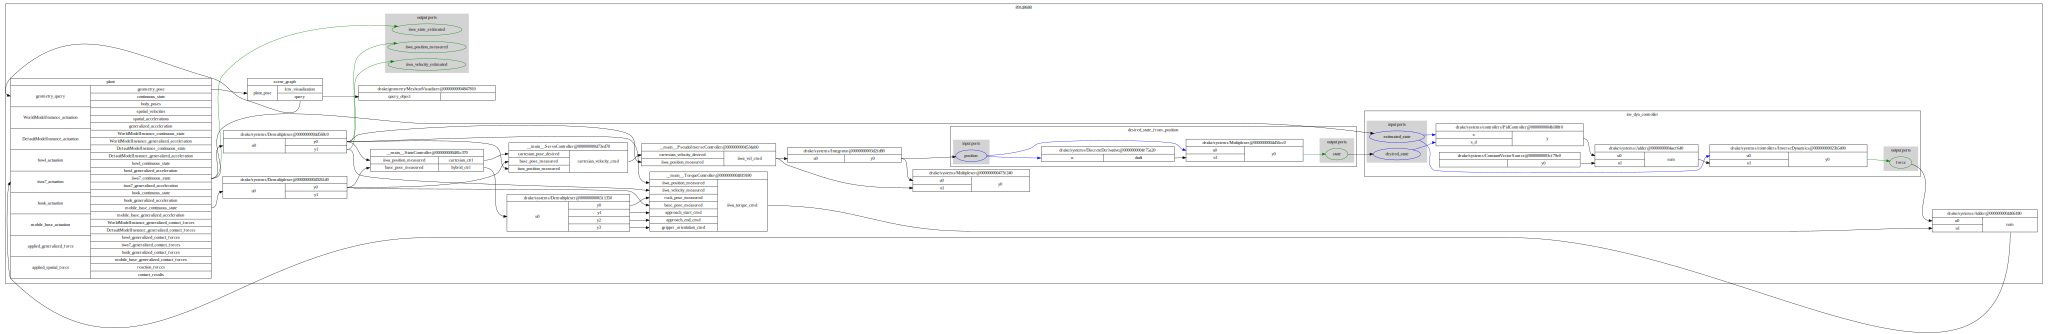

In [27]:
display(SVG(pydot.graph_from_dot_data(climber.diagram.GetGraphvizString())[0].create_svg()))

In [ ]:
# TODO: Add closed-loop controller for position in fromt of pseudo inverse controller
# take in desired position and current global positionas input, 
# NOTE: this version of the notebook shows the error in the pseudoinversecontroller - the math isn't "correct" enough to do this open-loop with a light base
# I think the pseudoinverse controller still is sending the same old joint commands, but because it's floating the inverse dynamics behaves differently?

"""
Roadmap:
- implement closed loop controller - get it to move to a specific pose
- create dummy stand-in for ethan's code - this outputs approach vector and grasp position
- modify state machine. Take in approach vector and grasp position. Compute pregrasp location, switch between states. 
    Output torque_ctl_inputs (approach start, approach end, gripper orientation)
    Output pose_ctl_inputs (cartesian pose command)
- modify torque controller - if all of it's inputs are 0, output 0 torque
- modify pseudoinverse controller - if all it's inputs are 0, output 0 velocity
- add multiplexer in-between state machine and torque ctrl
- finish implementation of torque controller
















Current status: I think the torque controller might be working, but to test it I need to set the 
state controller properly - Next steps:
- add a multiplexer in between state machine and torque ctrl
- visualize torque ctrl frames
- modify state controller to set poses properly
- end-to-end test
"""